<a href="https://colab.research.google.com/github/lab-jianghao/spark_ml_sample/blob/main/07_abnormal_distribution_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-17-jdk-headless

!wget https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz /content
!tar xf spark-3.5.0-bin-hadoop3.tgz

In [14]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [15]:
!pip install pyspark==3.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=9d5680a9ec16262d803eded20c86ea25d3fdede22f6675a0cd10add10c3f3d3f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [16]:
from functools import wraps
from pyspark.sql import SparkSession

def spark_sql_initializer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):

        spark = SparkSession.builder\
            .appName("Colab_SPARK_ML")\
            .master("local[*]")\
            .getOrCreate()

        spark.sparkContext.setLogLevel("WARN")

        func(spark,*args, **kwargs)

        spark.stop()

    return wrapper

In [9]:
import seaborn as sns

diamonds_df = sns.load_dataset("diamonds")
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


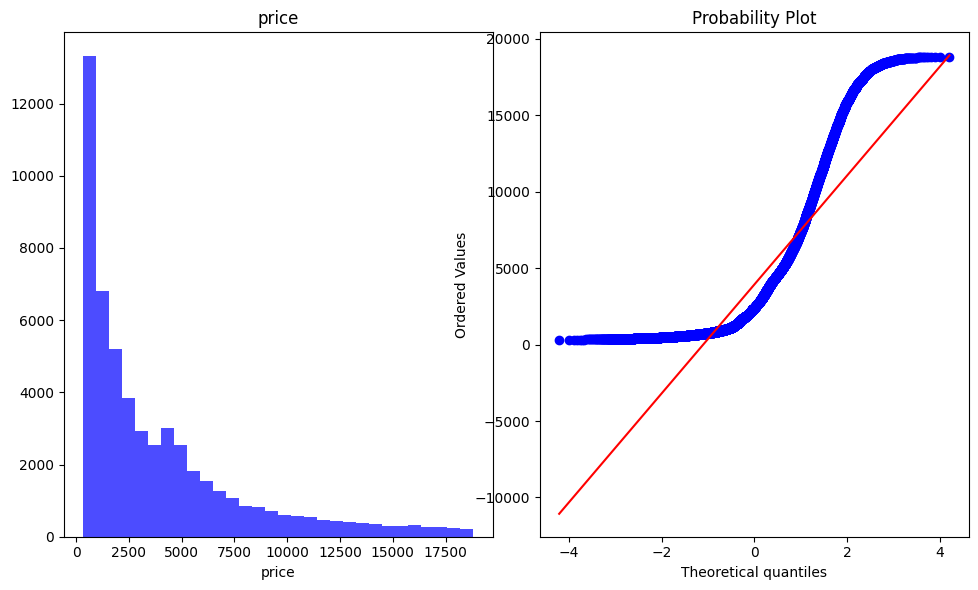

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import probplot


target_column = 'price'
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.hist(diamonds_df[target_column], bins=30, color='blue', alpha=0.7)
plt.title(target_column)
plt.xlabel(target_column)

plt.subplot(1, 2, 2)
plt.title(f'Q-Q plot of {target_column}')
plt.tight_layout()

probplot(diamonds_df[target_column], dist="norm", plot=plt)

plt.show()

In [55]:
from pyspark.ml import Pipeline

from pyspark.ml.regression import LinearRegression

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F


@spark_sql_initializer
def train_LR(spark, df):
    diamonds_df = spark.createDataFrame(df)
    diamonds_df.show()

    index_columns = ['cut', 'color', 'clarity']
    diamonds_df = diamonds_df.withColumnRenamed("price", "label")

    feature_indexes = [StringIndexer(inputCol=col, outputCol=f"indexed_{col}", handleInvalid="keep") for col in index_columns]
    for indexer in feature_indexes:
        diamonds_df = indexer.fit(diamonds_df).transform(diamonds_df)

    feature_columns = [col for col in diamonds_df.columns if col not in index_columns + ['label']]

    vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    diamonds_df = diamonds_df.drop(*list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)))

    lr = LinearRegression(featuresCol="features", labelCol="label", predictionCol="prediction")

    training_data, test_data = diamonds_df.randomSplit([0.7, 0.3], seed=1000)

    lr_pipeline = Pipeline(stages=feature_indexes + [vector_assembler, lr])
    lr_model = lr_pipeline.fit(training_data)
    lr_prediction = lr_model.transform(test_data)

    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(lr_prediction)
    print("Root Mean Squared Error (RMSE) = {:.2f}".format(rmse))

    lr_prediction.select("label", "prediction").show()

    print("-----------------------------------")
    intercept = lr_model.stages[-1].intercept
    print(f"Intercept: {intercept}")
    print("-----------------------------------")

    feature_weights = lr_model.stages[-1].coefficients
    feature_weights_dict = dict(zip(index_columns, feature_weights))

    sorted_weights = sorted(feature_weights_dict.items(), key=lambda x: abs(x[1]), reverse=True)
    print("Feature Weights:")
    for feature, weight in sorted_weights:
        print(f"{feature}: {weight}")
    print("-----------------------------------")


In [56]:
train_LR(diamonds_df.copy())

+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|
| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|
| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|
| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|
| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|
|  0.3|     Good|    J|    SI1| 64.0| 55.0|  339|4.25|4.28|2.73|
| 0.23|    Ideal|    J|    VS1| 62.8| 56.0|  340|3.93| 3.9|2.46|
| 0.22|  Premium|    F|  

In [57]:
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator


@spark_sql_initializer
def train_RF(spark, df):
    diamonds_df = spark.createDataFrame(df)
    diamonds_df.show()

    index_columns = ['cut', 'color', 'clarity']
    diamonds_df = diamonds_df.withColumnRenamed("price", "label")

    feature_indexes = [StringIndexer(inputCol=col, outputCol=f"indexed_{col}", handleInvalid="keep") for col in index_columns]
    for indexer in feature_indexes:
        diamonds_df = indexer.fit(diamonds_df).transform(diamonds_df)

    feature_columns = [col for col in diamonds_df.columns if col not in index_columns + ['label']]

    vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    diamonds_df = diamonds_df.drop(*list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)))

    rf = RandomForestRegressor(featuresCol="features", labelCol="label", predictionCol="prediction")

    training_data, test_data = diamonds_df.randomSplit([0.7, 0.3], seed=1000)

    rf_pipeline = Pipeline(stages=feature_indexes + [vector_assembler, rf])
    rf_model = rf_pipeline.fit(training_data)
    rf_prediction = rf_model.transform(test_data)

    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(rf_prediction)
    print("Root Mean Squared Error (RMSE) = {:.2f}".format(rmse))

    rf_prediction.select("label", "prediction").show()

    print("-----------------------------------")

    feature_importances = rf_model.stages[-1].featureImportances
    feature_importances_dict = dict(zip(feature_columns, feature_importances))

    sorted_importances = sorted(feature_importances_dict.items(), key=lambda x: abs(x[1]), reverse=True)
    print("Feature Importances:")
    for feature, importance in sorted_importances:
        print(f"{feature}: {importance}")
    print("-----------------------------------")


In [59]:
train_RF(diamonds_df.copy())

+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|
| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|
| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|
| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|
| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|
|  0.3|     Good|    J|    SI1| 64.0| 55.0|  339|4.25|4.28|2.73|
| 0.23|    Ideal|    J|    VS1| 62.8| 56.0|  340|3.93| 3.9|2.46|
| 0.22|  Premium|    F|  

In [60]:
from pyspark.ml.regression import GBTRegressor

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

@spark_sql_initializer
def train_GBT(spark, df):
    diamonds_df = spark.createDataFrame(df)
    diamonds_df.show()

    index_columns = ['cut', 'color', 'clarity']
    diamonds_df = diamonds_df.withColumnRenamed("price", "label")

    feature_indexes = [StringIndexer(inputCol=col, outputCol=f"indexed_{col}", handleInvalid="keep") for col in index_columns]
    for indexer in feature_indexes:
        diamonds_df = indexer.fit(diamonds_df).transform(diamonds_df)

    feature_columns = [col for col in diamonds_df.columns if col not in index_columns + ['label']]

    vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    diamonds_df = diamonds_df.drop(*list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)))

    gbt = GBTRegressor(featuresCol="features", labelCol="label", predictionCol="prediction")

    training_data, test_data = diamonds_df.randomSplit([0.7, 0.3], seed=1000)

    gbt_pipeline = Pipeline(stages=feature_indexes + [vector_assembler, gbt])
    gbt_model = gbt_pipeline.fit(training_data)
    gbt_prediction = gbt_model.transform(test_data)

    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(gbt_prediction)
    print("Root Mean Squared Error (RMSE) = {:.2f}".format(rmse))

    gbt_prediction.select("label", "prediction").show()

    print("-----------------------------------")

    feature_importances = gbt_model.stages[-1].featureImportances
    feature_importances_dict = dict(zip(feature_columns, feature_importances))

    sorted_importances = sorted(feature_importances_dict.items(), key=lambda x: abs(x[1]), reverse=True)
    print("Feature Importances:")
    for feature, importance in sorted_importances:
        print(f"{feature}: {importance}")
    print("-----------------------------------")


In [61]:
train_GBT(diamonds_df.copy())

+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|
| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|
| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|
| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|
| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|
|  0.3|     Good|    J|    SI1| 64.0| 55.0|  339|4.25|4.28|2.73|
| 0.23|    Ideal|    J|    VS1| 62.8| 56.0|  340|3.93| 3.9|2.46|
| 0.22|  Premium|    F|  

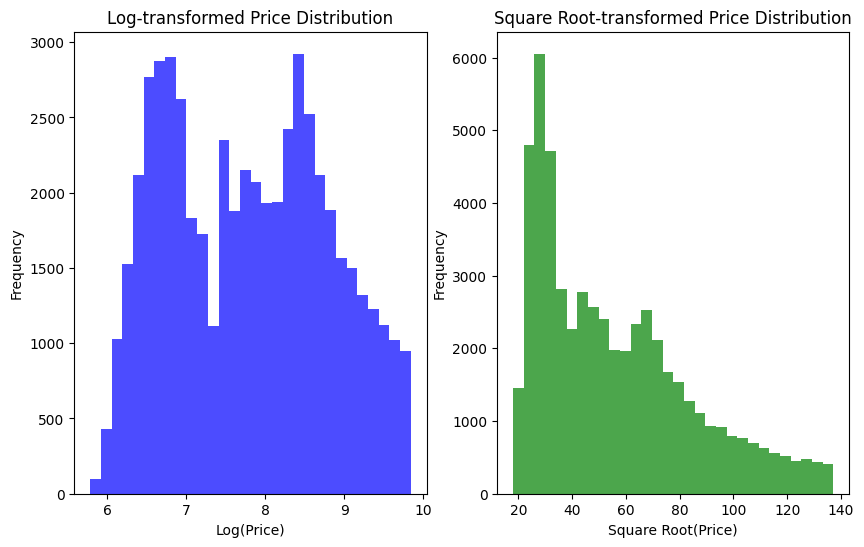

In [68]:
import numpy as np
import matplotlib.pyplot as plt

prices = diamonds_df['price']

log_prices = np.log(prices)
sqrt_prices = np.sqrt(prices)

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.hist(log_prices, bins=30, color='blue', alpha=0.7)
plt.title('Log-transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(sqrt_prices, bins=30, color='green', alpha=0.7)
plt.title('Square Root-transformed Price Distribution')
plt.xlabel('Square Root(Price)')
plt.ylabel('Frequency')

plt.show()



In [65]:
from pyspark.ml.regression import GBTRegressor

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.functions import log, col, exp

@spark_sql_initializer
def train_log_GBT(spark, df):
    diamonds_df = spark.createDataFrame(df)
    diamonds_df.show()

    index_columns = ['cut', 'color', 'clarity']
    diamonds_df = diamonds_df.withColumn("label", log(col("price") + 1))

    feature_indexes = [StringIndexer(inputCol=col, outputCol=f"indexed_{col}", handleInvalid="keep") for col in index_columns]
    for indexer in feature_indexes:
        diamonds_df = indexer.fit(diamonds_df).transform(diamonds_df)

    feature_columns = [col for col in diamonds_df.columns if col not in index_columns + ['label']]

    vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    diamonds_df = diamonds_df.drop(*list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)))


    gbt = GBTRegressor(featuresCol="features", labelCol="label", predictionCol="prediction")

    training_data, test_data = diamonds_df.randomSplit([0.7, 0.3], seed=1000)

    gbt_pipeline = Pipeline(stages=feature_indexes + [vector_assembler, gbt])
    gbt_model = gbt_pipeline.fit(training_data)
    gbt_prediction = gbt_model.transform(test_data)

    gbt_prediction = gbt_prediction.withColumn("predicted_price", exp("prediction"))


    evaluator = RegressionEvaluator(labelCol="price", predictionCol="predicted_price", metricName="rmse")
    rmse = evaluator.evaluate(gbt_prediction)
    print("Root Mean Squared Error (RMSE) = {:.2f}".format(rmse))

    gbt_prediction.select("price", "predicted_price").show()

    print("-----------------------------------")

    feature_importances = gbt_model.stages[-1].featureImportances
    feature_importances_dict = dict(zip(feature_columns, feature_importances))

    sorted_importances = sorted(feature_importances_dict.items(), key=lambda x: abs(x[1]), reverse=True)
    print("Feature Importances:")
    for feature, importance in sorted_importances:
        print(f"{feature}: {importance}")
    print("-----------------------------------")


In [66]:
train_log_GBT(diamonds_df.copy())

+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|
| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|
| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|
| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|
| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|
|  0.3|     Good|    J|    SI1| 64.0| 55.0|  339|4.25|4.28|2.73|
| 0.23|    Ideal|    J|    VS1| 62.8| 56.0|  340|3.93| 3.9|2.46|
| 0.22|  Premium|    F|  